## 序列模型
>现实生活中有很多数据是具有时序结构的

- 解决时许预测问题， **本质上是一个自回归问题**

<img src='../images/51image1.png' width='400'>

- 解决时许问题的方法
1. **马尔可夫假设**

<img src='../images/51image3.png' width='400'>

2. **基于潜变量**


**注：**隐变量和潜变量并不是同一个概念，隐变量大多指的是在现实生活中存在的但是没有被人观察到的东西，潜变量则是包括了隐变量，可以由人构造的变量

<img src='../images/51image2.png' width='400'>

### 总结
1. 时许模型中，当前数据和之前观察到的数据相关
2. 自回归模型使用自身过去数据预测未来数据
3. 马尔可夫预测模型假设当前只跟最近少数数据相关，从而简化模型
4. 潜变量模型通过使用潜变量$h_t$来概括之前的历史信息

- 生成一些数据

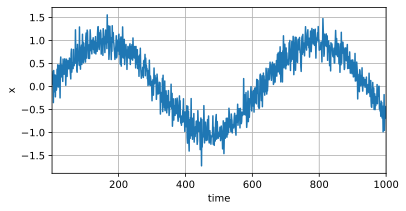

In [20]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
# plt.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

- 我们基于马尔可夫假设来训练模型，假设$x_t$只与前$\tau$个数据相关,同时我们生成相应的数据对，数据集会比我们拥有的时间序列少$\tau$个

In [21]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i] # 选T - tau个元素，分别放入features中的四列
labels = x[tau:].reshape(-1, 1)

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

- 使用一个简单的全连接神经网络进行训练

In [22]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)

    return net

loss = nn.MSELoss(reduction='none')

In [23]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.061327
epoch 2, loss: 0.055025
epoch 3, loss: 0.054206
epoch 4, loss: 0.052325
epoch 5, loss: 0.051911


- 进行单步预测(给定时间点t的数据特征，预测t时间点的值)

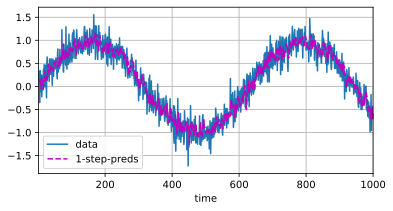

In [24]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()],
         'time', legend=['data', '1-step-preds'], xlim=[1, 1000], figsize=(6, 3))

- k步预测，对于数据到了$x_t$的观测序列，其在时间步$t + k$输出的预测$\hat{x}_{t+k}$称为k步预测

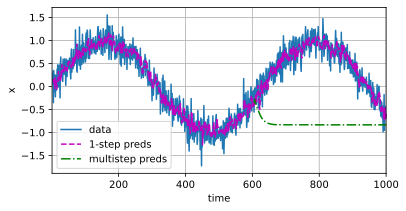

In [25]:
multistep_preds = torch.zeros(T)
# 这里假设我们看到了604
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape(1, -1))
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

- 从多步预测的结果我们可以看出，没预测出来几个就趋于一个常数，这是因为错误的累计

<img src='../images/51image4.png' width='800'>

- 基于$k=1,4,16,64$，对整个序列做预测计算

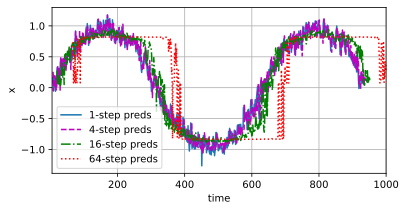

In [26]:
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

# 对于前tau列，就是观测值
for i in range(tau):
    features[:, i] = x[i: T - tau - max_steps + 1 + i]

# 对于后面的列，则需要逐步预测：
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = [1, 4, 16, 64]
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps], 
         [features[:, (tau + i - 1)].detach().numpy() for i in steps],
         'time', 'x', legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))